In [1]:
import json

with open("./data/coords.json", "r") as f:
    coords = json.loads(f.read())['coords']

/tmp/ipykernel_516798/3543631731.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ls = algo.labels_.astype(np.int)


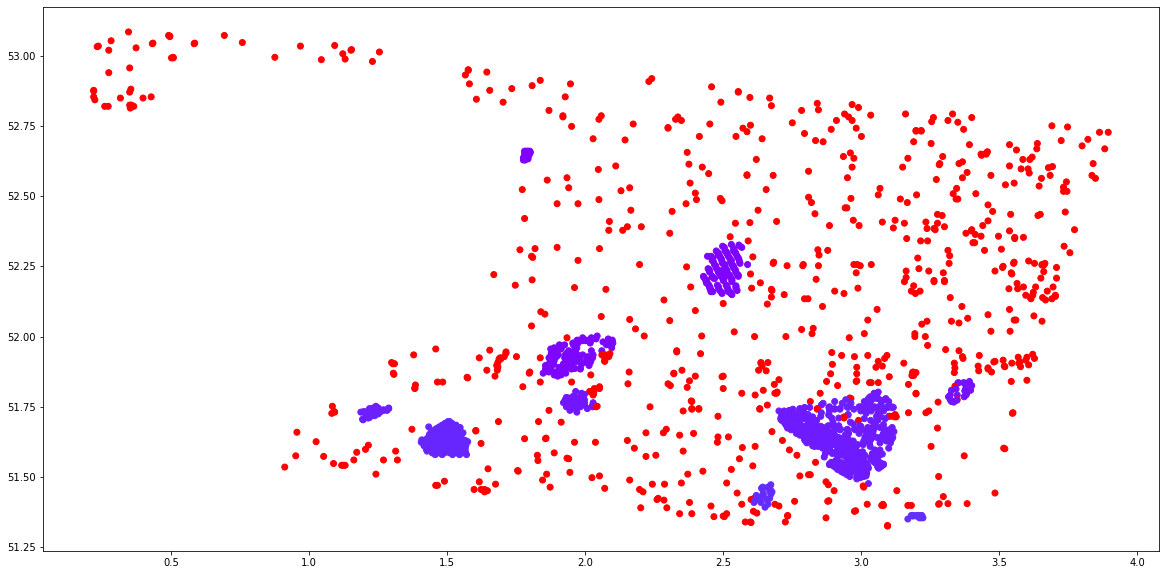

             X          Y  cluster
0     0.346406  53.085610       -1
1     0.491556  53.072988       -1
2     0.693504  53.072988       -1
3     0.495763  53.070884       -1
4     0.495763  53.068781       -1
...        ...        ...      ...
1807  2.599392  51.339598       -1
1808  2.725609  51.339598       -1
1809  2.601495  51.337495       -1
1810  3.095848  51.326977       -1
1811  3.095848  51.324873       -1

[1812 rows x 3 columns]


In [8]:
from sklearn import cluster
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

colors = cm.rainbow(np.linspace(0, 1, 200))


def apply(xx, algo):
    algo.fit(xx)
    ls = algo.labels_.astype(np.int)
    plt.scatter(xx[:, 0], xx[:, 1], color=colors[labels])
    plt.show()
    return ls


df = pd.DataFrame(coords)
x = df.to_numpy()
labels = apply(x, cluster.DBSCAN(eps=.03, min_samples=10))

plt.rcParams["figure.figsize"] = [20, 10]
cluster_map = pd.DataFrame()
cluster_map['X'] = x[:, 0]
cluster_map['Y'] = x[:, 1]
cluster_map['cluster'] = labels

print(cluster_map)

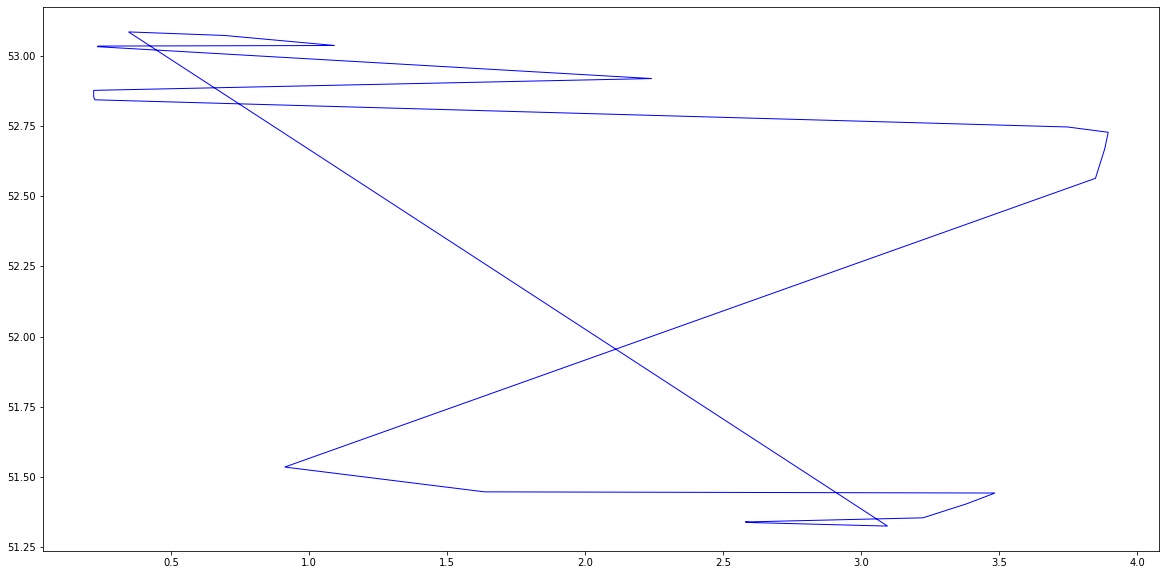

array([[ 0.34640578, 53.08560982],
       [ 0.69350444, 53.07298805],
       [ 1.0931938 , 53.03722637],
       [ 0.23701711, 53.03512274],
       [ 0.23280986, 53.03301912],
       [ 2.24177482, 52.91942319],
       [ 0.22018809, 52.87735063],
       [ 0.22018809, 52.85421072],
       [ 0.22439534, 52.84369257],
       [ 3.74797263, 52.74692568],
       [ 3.89522661, 52.72799302],
       [ 3.88260484, 52.66909143],
       [ 3.84894679, 52.56391002],
       [ 0.91228178, 51.53523581],
       [ 1.63592989, 51.44688343],
       [ 3.4850191 , 51.44267617],
       [ 3.38404495, 51.40481086],
       [ 3.2241692 , 51.35432379],
       [ 2.58045897, 51.33959839],
       [ 2.60149525, 51.33749476],
       [ 3.09584788, 51.32487299]])

In [24]:
from scipy import spatial

poly = spatial.ConvexHull(coords)
import matplotlib.pyplot as plt
hull_indices = np.unique(poly.simplices.flat)
hull_pts = np.array(coords)[hull_indices]
plt.fill(hull_pts[:,0], hull_pts[:,1], fill=False, edgecolor='b')
plt.show()
hull_pts

In [ ]:
from shapely.geometry import LineString
import geopandas as gpd


def bounding_box(x_coordinates, y_coordinates):
    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]


list_lon = []
list_lat = []
list_geom = []

column_values = cluster_map["cluster"].values
clusters = np.unique(column_values)
bboxs = []
for cluster in clusters:
    if cluster_map[cluster_map.cluster == cluster].shape[0] <= 20:
        continue
    bboxs.append(bounding_box(cluster_map[cluster_map.cluster == cluster]['X'],
                              cluster_map[cluster_map.cluster == cluster]['Y']))

l_lats = []
l_lons = []
boxes = []
for bbox in bboxs:
    l_lats.append(bbox[0][0])
    l_lats.append(bbox[1][0])
    l_lats.append(bbox[1][0])
    l_lats.append(bbox[0][0])
    l_lats.append(bbox[0][0])
    l_lons.append(bbox[0][1])
    l_lons.append(bbox[0][1])
    l_lons.append(bbox[1][1])
    l_lons.append(bbox[1][1])
    l_lons.append(bbox[0][1])

    bb = gpd.points_from_xy(l_lats, l_lons, crs="EPSG:4326")

    boxes.append(LineString(bb))
    l_lats = []
    l_lons = []

df_result = gpd.GeoDataFrame({
    'geometry': boxes
})

df_result['geometry']
from shapely.ops import unary_union

cu = unary_union(df_result['geometry']);
df2_result = gpd.GeoDataFrame({
    'geometry': cu
})

df2_result.crs = 'epsg:4326'
df2_result.to_file("result.shp")